# Forward Optical and Photonic Model

A forward photonic model is developed for a two-aperture optical interferometer
observing a binary stellar source. The formulation is based on wave-optical
principles and provides a quantitative description of photon detection statistics
in terms of underlying astrophysical parameters.

The model yields the mean detected photon number $\lambda(\theta)$ as a function
of source and instrument parameters, enabling direct comparison between theory
and observation. Its behavior is examined in physically relevant limiting cases
to ensure internal consistency and correspondence with established results.

All assumptions and approximations are stated explicitly and incorporated at the
level of model configuration, ensuring transparency and reproducibility of the
forward modeling framework.

In [1]:
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
CONFIG_DIR = PROJECT_ROOT / "config"

assert CONFIG_DIR.exists(), "Config directory not found. Check project structure."

In [3]:
with open(CONFIG_DIR / "physical_constants.yaml", "r") as f:
    phys = yaml.safe_load(f)

with open(CONFIG_DIR / "astrophysical_model.yaml", "r") as f:
    astro_cfg = yaml.safe_load(f)

with open(CONFIG_DIR / "optical_system.yaml", "r") as f:
    optics_cfg = yaml.safe_load(f)

with open(CONFIG_DIR / "detector_and_noise.yaml", "r") as f:
    detector_cfg = yaml.safe_load(f)

In [4]:
# Astrophysical scenario
assert astro_cfg["source"]["type"] == "binary_star", (
    "Forward model defined only for binary star sources."
)

# Optical architecture
assert optics_cfg["aperture"]["type"] == "two_telescope_interferometer", (
    "Forward model assumes a two-telescope interferometer."
)

# Noise regime
assert detector_cfg["noise"]["shot_noise"]["enabled"] is True, (
    "Photon statistics must be shot-noise limited."
)

## Interferometric Signal Model

We analyze a two-aperture optical interferometer observing a binary stellar
source characterized by an angular separation $\theta$ and a flux ratio
$r = F_2 / F_1$. Within the framework of scalar wave optics, the mean detected
photon number per exposure at a given interferometric output port is given by
$$
\lambda(\theta, r) = N_0 \left[ 1 + r + 2 \sqrt{r} \cos(\phi) \right].
$$

The interferometric phase $\phi$ is defined as
$$
\phi = \frac{2 \pi B \theta}{\lambda},
$$
where $B$ denotes the interferometer baseline, $\lambda$ is the optical
wavelength, and $N_0$ is a dimensionless normalization factor setting the overall
photon-number scale.

This expression captures the coherent interference between the two stellar
components and forms the basis for subsequent statistical modeling of the
detected photon counts.

## Monochromatic Approximation

The forward model is formulated under the assumption of quasi-monochromatic
detection. The optical bandwidth is taken to be sufficiently narrow such that
the temporal coherence length greatly exceeds the interferometric path delay,
ensuring that fringe visibility is not appreciably reduced by spectral
averaging.

Under these conditions, the interferometric response may be described using a
single effective wavelength. Extensions to account for finite bandwidth and
partial temporal coherence are deferred to subsequent analyses.

In [6]:
baseline = optics_cfg["aperture"]["baseline"]
wavelength = optics_cfg["wavelength"]["central"]

assert baseline is not None, (
    "Interferometer baseline must be specified in optical_system.yaml"
)

assert wavelength is not None, (
    "Central wavelength must be specified in optical_system.yaml"
)

In [7]:
def photon_number_normalization():
    """
    Dimensionless mean photon number per exposure.

    This normalization is intentionally abstract at this stage.
    Absolute flux calibration, detector efficiency, and exposure time
    will be incorporated in later notebooks.
    """
    return 1.0

In [8]:
def mean_photon_number(theta):
    """
    Mean detected photon number for a two-aperture interferometer
    observing a binary star.

    Parameters
    ----------
    theta : array-like of length 2
        theta[0] : angular separation [radians]
        theta[1] : flux ratio r = F2 / F1

    Returns
    -------
    lambda_mean : float
        Mean photon number per exposure
    """
    theta_sep, flux_ratio = theta

    # Physical parameter checks
    if theta_sep < 0:
        raise ValueError("Angular separation must be non-negative.")
    if not (0 < flux_ratio <= 1):
        raise ValueError("Flux ratio must lie in (0, 1].")

    # Interferometric phase
    phase = 2 * np.pi * baseline * theta_sep / wavelength

    # Photon number model
    N0 = photon_number_normalization()
    lambda_mean = N0 * (
        1 + flux_ratio + 2 * np.sqrt(flux_ratio) * np.cos(phase)
    )

    # Physical admissibility
    if lambda_mean < 0:
        raise RuntimeError(
            "Unphysical negative photon number encountered."
        )

    return lambda_mean

In [9]:
# θ → 0 : maximum constructive interference
lambda_zero_sep = mean_photon_number([0.0, 0.5])

# r → 0 : single-star limit
lambda_single_star = mean_photon_number([1e-9, 1e-6])

lambda_zero_sep, lambda_single_star

(np.float64(2.914213562373095), np.float64(1.0006190339887497))

In [10]:
theta_base = 1e-9
theta_shifted = theta_base + wavelength / baseline

rate_1 = mean_photon_number([theta_base, 0.5])
rate_2 = mean_photon_number([theta_shifted, 0.5])

assert np.isclose(rate_1, rate_2, atol=1e-8), (
    "Interferometric photon number is not phase-periodic."
)

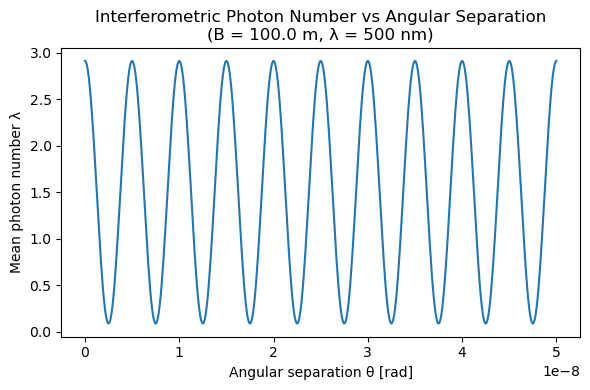

In [11]:
theta_vals = np.linspace(0, 5e-8, 500)
rates = [mean_photon_number([t, 0.5]) for t in theta_vals]

plt.figure(figsize=(6, 4))
plt.plot(theta_vals, rates)
plt.xlabel("Angular separation θ [rad]")
plt.ylabel("Mean photon number λ")
plt.title(
    f"Interferometric Photon Number vs Angular Separation\n"
    f"(B = {baseline:.1f} m, λ = {wavelength*1e9:.0f} nm)"
)
plt.tight_layout()
plt.show()